In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import multiprocessing
from pyspark.sql import SQLContext
from sklearn.linear_model import LogisticRegression
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn import utils
from tqdm import tqdm

In [2]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
df = pd.read_csv('/Users/anshul/ML/song_genre/lyrics.csv')

In [4]:
df.shape

(362237, 6)

In [5]:
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [6]:
df = df[pd.notnull(df['lyrics'])]
df = df.drop("song", axis=1)
df = df.drop("year", axis=1)
df = df.drop("artist", axis=1)
df = df.drop("index", axis=1)

In [7]:
df.shape

(266557, 2)

In [8]:
df.index = range(266557)

In [9]:
print(df['lyrics'])

0         Oh baby, how you doing?\nYou know I'm gonna cu...
1         playin' everything so easy,\nit's like you see...
2         If you search\nFor tenderness\nIt isn't hard t...
3         Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4         Party the people, the people the party it's po...
5         I heard\nChurch bells ringing\nI heard\nA choi...
6         This is just another day that I would spend\nW...
7         Waiting, waiting, waiting, waiting\nWaiting, w...
8         [Verse 1:]\nI read all of the magazines\nwhile...
9         N-n-now, honey\nYou better sit down and look a...
10        I lay alone awake at night\nSorrow fills my ey...
11        Hello hello baby you called\nI can't hear a th...
12        Feels like I'm losing my mind\nLove is so hard...
13        Youre everything I thought you never were\nAnd...
14        I gotta give up\nto quite the storm that rages...
15        It really hurts to say this yes it does\nBut a...
16        You're bad for me I clearly ge

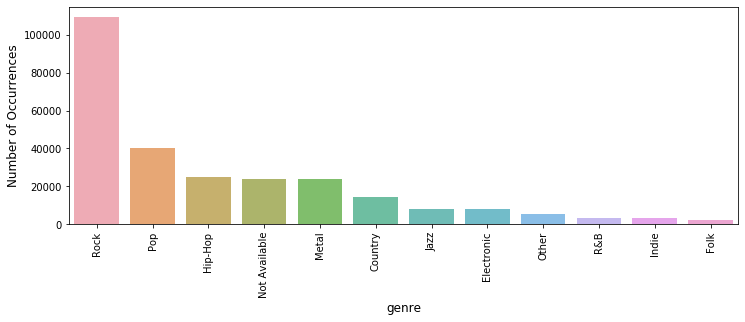

In [10]:
cnt_pro = df['genre'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('genre', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
#genre = y.value_counts()

In [12]:
#print (genre)

In [13]:
#plt.figure(figsize=(12,4))
#sns.barplot(genre.index, genre.values, alpha=0.8)

In [14]:
#plt.ylabel('Number of Occurrences', fontsize=12)

In [15]:
#plt.xlabel('Genre', fontsize=12)

In [16]:
#plt.show()

In [17]:
print (df['lyrics'])

0         Oh baby, how you doing?\nYou know I'm gonna cu...
1         playin' everything so easy,\nit's like you see...
2         If you search\nFor tenderness\nIt isn't hard t...
3         Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4         Party the people, the people the party it's po...
5         I heard\nChurch bells ringing\nI heard\nA choi...
6         This is just another day that I would spend\nW...
7         Waiting, waiting, waiting, waiting\nWaiting, w...
8         [Verse 1:]\nI read all of the magazines\nwhile...
9         N-n-now, honey\nYou better sit down and look a...
10        I lay alone awake at night\nSorrow fills my ey...
11        Hello hello baby you called\nI can't hear a th...
12        Feels like I'm losing my mind\nLove is so hard...
13        Youre everything I thought you never were\nAnd...
14        I gotta give up\nto quite the storm that rages...
15        It really hurts to say this yes it does\nBut a...
16        You're bad for me I clearly ge

In [18]:
def cleanText(text):
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('\n', ' ')
    return text
df['lyrics'] = df['lyrics'].apply(cleanText)

In [19]:
print(df['lyrics'])

0         oh baby, how you doing? you know i'm gonna cut...
1         playin' everything so easy, it's like you seem...
2         if you search for tenderness it isn't hard to ...
3         oh oh oh i, oh oh oh i [verse 1:] if i wrote a...
4         party the people, the people the party it's po...
5         i heard church bells ringing i heard a choir s...
6         this is just another day that i would spend wa...
7         waiting, waiting, waiting, waiting waiting, wa...
8         [verse 1:] i read all of the magazines while w...
9         n-n-now, honey you better sit down and look ar...
10        i lay alone awake at night sorrow fills my eye...
11        hello hello baby you called i can't hear a thi...
12        feels like i'm losing my mind love is so hard ...
13        youre everything i thought you never were and ...
14        i gotta give up to quite the storm that rages ...
15        it really hurts to say this yes it does but af...
16        you're bad for me i clearly ge

In [20]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [21]:
train.head()
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['lyrics']), tags=[r.genre]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['lyrics']), tags=[r.genre]), axis=1)

In [22]:
train_tagged[0]

TaggedDocument(words=['oh', 'baby', 'how', 'you', 'doing', 'you', 'know', "'m", 'gon', 'na', 'cut', 'right', 'to', 'the', 'chase', 'some', 'women', 'were', 'made', 'but', 'me', 'myself', 'like', 'to', 'think', 'that', 'was', 'created', 'for', 'special', 'purpose', 'you', 'know', 'what', "'s", 'more', 'special', 'than', 'you', 'you', 'feel', 'me', 'it', "'s", 'on', 'baby', 'let', "'s", 'get', 'lost', 'you', 'do', "n't", 'need', 'to', 'call', 'into', 'work', "'cause", 'you', "'re", 'the', 'boss', 'for', 'real', 'want', 'you', 'to', 'show', 'me', 'how', 'you', 'feel', 'consider', 'myself', 'lucky', 'that', "'s", 'big', 'deal', 'why', 'well', 'you', 'got', 'the', 'key', 'to', 'my', 'heart', 'but', 'you', 'ai', "n't", 'gon', 'na', 'need', 'it', "'d", 'rather', 'you', 'open', 'up', 'my', 'body', 'and', 'show', 'me', 'secrets', 'you', 'did', "n't", 'know', 'was', 'inside', 'no', 'need', 'for', 'me', 'to', 'lie', 'it', "'s", 'too', 'big', 'it', "'s", 'too', 'wide', 'it', "'s", 'too', 'strong',

In [23]:
cores = multiprocessing.cpu_count()

In [24]:
print(cores)

4


In [25]:
train_tagged.values

array([TaggedDocument(words=['was', "n't", 'having', 'it', 'all', 'that', 'day', 'having', 'thought', 'was', 'there', 'is', 'fine', 'do', "n't", 'know', 'what', 'can', 'be', 'hard', 'to', 'say', 'oh', 'that', "'s", 'sign', 'of', 'better', 'time', 'you', 'know', 'now', 'the', 'hours', 'that', 'go', 'in', 'front', 'of', 'me', 'remind', 'it', 'how', 'it', 'used', 'to', 'be', 'and', 'you', 'down', 'in', 'the', 'grass', 'with', 'me', 'the', 'hours', 'of', 'choking', 'century', 'blame', 'you', 'thank', 'you', 'blame', 'you', 'was', "n't", 'fit', 'to', 'have', 'you', 'but', 'will', 'never', 'run', 'and', 'hide', "'ll", 'feel', 'so', 'bad', 'and', 'then', 'will', 'not', 'apologize', 'am', 'fit', 'to', 'hang', 'and', 'in', 'the', 'falling', 'rain', 'and', 'meant', 'to', 'make', 'it', 'out', 'tonight', 'the', 'hours', 'that', 'go', 'in', 'front', 'of', 'me', 'remind', 'it', 'how', 'it', 'used', 'be', 'and', 'you', 'down', 'in', 'the', 'grass', 'with', 'me', 'the', 'hours', 'of', 'choking', 'cent

In [26]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 186589/186589 [00:00<00:00, 2227985.19it/s]


In [27]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 186589/186589 [00:00<00:00, 2782834.53it/s]


CPU times: user 50min 28s, sys: 41.9 s, total: 51min 10s
Wall time: 1h 2min 31s


In [28]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))